# 0. Vehicle Price Prediction - AutoML with Scikit-learn

This notebook implements an automated machine learning pipeline for predicting vehicle prices using multiple regression algorithms and hyperparameter optimization.

In [3]:
import sys, os, datetime, joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    median_absolute_error,
    mean_absolute_percentage_error,
    explained_variance_score,
    mean_squared_log_error,
)
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

print(f"Python executable: {sys.executable}")
if 'venv_app' not in sys.executable:
    print('Warning: expected to run in venv_app')

Python executable: c:\Users\alvar\Documents\projects_git\car_value\venv_app\Scripts\python.exe


# 1. Load and Prepare Data

In [4]:
df = pd.read_pickle('../data/processed/df_auto.pkl')

# Rename fuelType to fuel_type for consistency
if 'fuelType' in df.columns:
    df = df.rename(columns={'fuelType': 'fuel_type'})

# Select features and remove missing values
df = df[['km','fuel_type','age','brand','segment','body_type','price_calc']].dropna()

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (16825, 7)


,km,fuel_type,age,brand,segment,body_type,price_calc
0,148634.0,gasolina,1,audi,C,Hatchback,15100
1,166000.0,gasolina,8,audi,C,Hatchback,14800
2,79900.0,diesel,9,audi,C,Hatchback,21990
3,151000.0,gasolina,8,audi,C,Hatchback,16900
4,114000.0,gasolina,7,audi,C,Hatchback,17450


# 2. Exploratory Data Analysis (EDA)

In [5]:
# Count of cars by each category
import matplotlib.pyplot as plt
import numpy as np

print("="*70)
print(f"{'VEHICLE COUNT BY CATEGORY':^70}")
print("="*70)

# Fuel Type
print(f"\n{'Fuel Type':-^70}")
fuel_counts = df['fuel_type'].value_counts()
for fuel, count in fuel_counts.items():
    pct = count / len(df) * 100
    print(f"  {fuel:20} {count:>6,} ({pct:5.1f}%)")

# Brand
print(f"\n{'Brand':-^70}")
brand_counts = df['brand'].value_counts()
for brand, count in brand_counts.items():
    pct = count / len(df) * 100
    print(f"  {brand:20} {count:>6,} ({pct:5.1f}%)")

# Segment
print(f"\n{'Segment':-^70}")
segment_counts = df['segment'].value_counts()
for segment, count in segment_counts.items():
    pct = count / len(df) * 100
    print(f"  {segment:20} {count:>6,} ({pct:5.1f}%)")

# Body Type
print(f"\n{'Body Type':-^70}")
body_counts = df['body_type'].value_counts()
for body, count in body_counts.items():
    pct = count / len(df) * 100
    print(f"  {body:20} {count:>6,} ({pct:5.1f}%)")

# Age (individual years)
print(f"\n{'Age (years)':-^70}")
age_counts = df['age'].value_counts().sort_index()
for age, count in age_counts.items():
    pct = count / len(df) * 100
    print(f"  {age:20} {count:>6,} ({pct:5.1f}%)")

# KM (grouped)
print(f"\n{'Mileage (km)':-^70}")
km_bins = [0, 50000, 100000, 150000, 200000, df['km'].max()+1]
km_labels = ['0-50k', '50-100k', '100-150k', '150-200k', '200k+']
df['km_group'] = pd.cut(df['km'], bins=km_bins, labels=km_labels, right=False)
km_counts = df['km_group'].value_counts().sort_index()
for km_grp, count in km_counts.items():
    pct = count / len(df) * 100
    print(f"  {km_grp:20} {count:>6,} ({pct:5.1f}%)")

print(f"\n{'='*70}")
print(f"Total Vehicles: {len(df):,}")
print(f"{'='*70}")

                      VEHICLE COUNT BY CATEGORY                       

------------------------------Fuel Type-------------------------------
  diesel                8,460 ( 50.3%)
  gasolina              5,691 ( 33.8%)
  hibrido               1,549 (  9.2%)
  electrico               749 (  4.5%)
  hibrido ench.           158 (  0.9%)
  glp                     158 (  0.9%)
  cng                      60 (  0.4%)

--------------------------------Brand---------------------------------
  vw                    2,931 ( 17.4%)
  seat                  1,906 ( 11.3%)
  nissan                1,873 ( 11.1%)
  renault               1,701 ( 10.1%)
  hyundai               1,537 (  9.1%)
  audi                  1,343 (  8.0%)
  dacia                 1,120 (  6.7%)
  kia                   1,048 (  6.2%)
  citroen                 827 (  4.9%)
  skoda                   781 (  4.6%)
  toyota                  552 (  3.3%)
  opel                    535 (  3.2%)
  mazda                   386 (  2.3%)
  tes

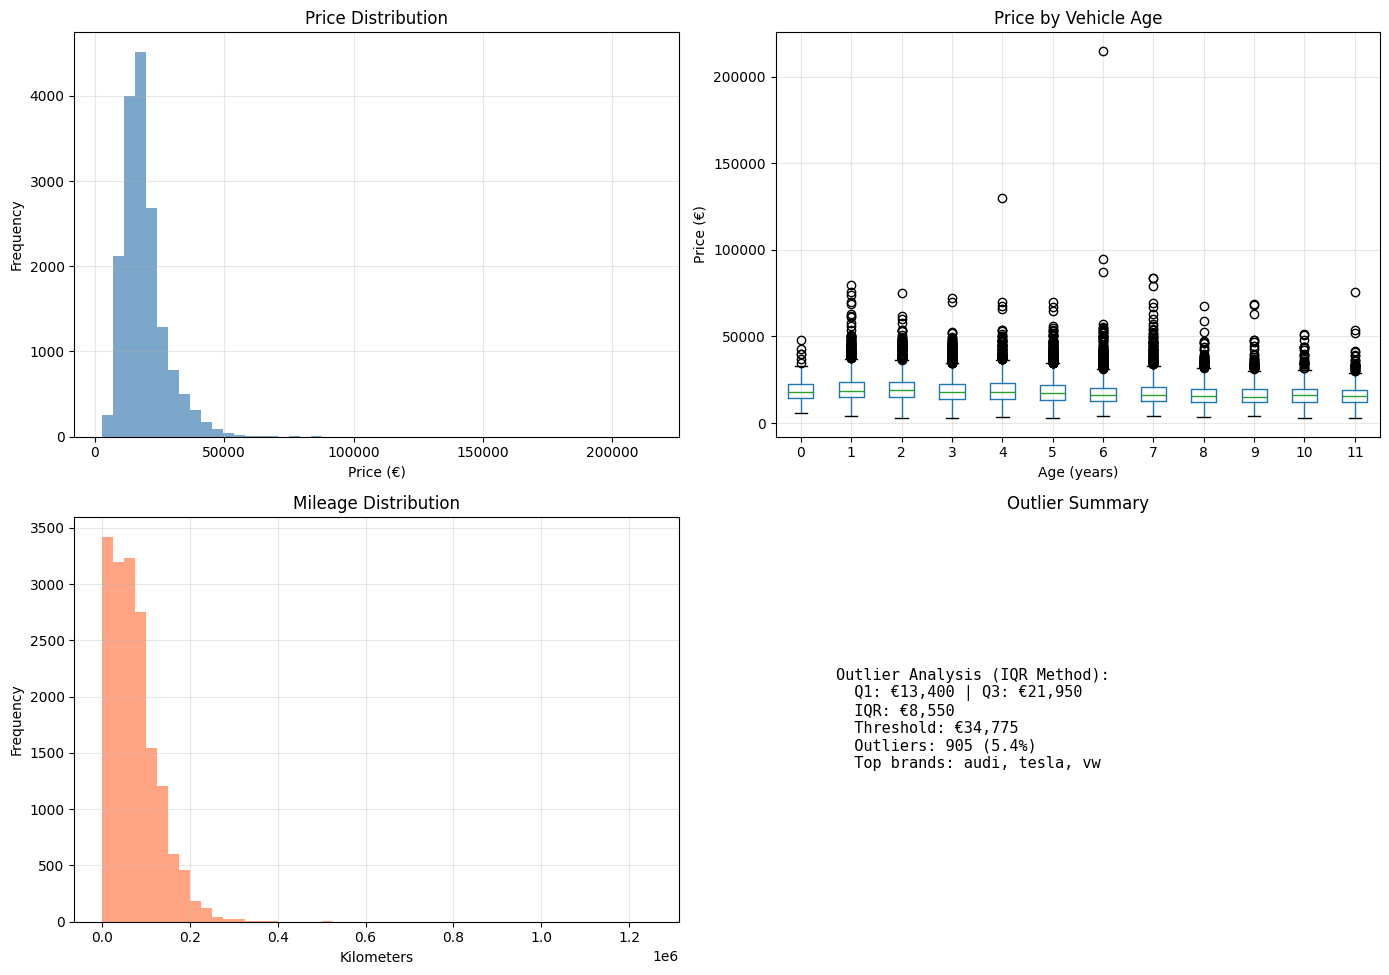

In [6]:
# Price distribution and outlier detection
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price histogram
axes[0, 0].hist(df['price_calc'], bins=50, color='steelblue', alpha=0.7)
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price (€)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Price by age
df.boxplot(column='price_calc', by='age', ax=axes[0, 1])
axes[0, 1].set_title('Price by Vehicle Age')
axes[0, 1].set_xlabel('Age (years)')
axes[0, 1].set_ylabel('Price (€)')
plt.suptitle('')
axes[0, 1].grid(True, alpha=0.3)

# KM distribution
axes[1, 0].hist(df['km'], bins=50, color='coral', alpha=0.7)
axes[1, 0].set_title('Mileage Distribution')
axes[1, 0].set_xlabel('Kilometers')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Outlier summary using IQR
Q1 = df['price_calc'].quantile(0.25)
Q3 = df['price_calc'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR
outliers = df[df['price_calc'] > outlier_threshold]

outlier_summary = f"Outlier Analysis (IQR Method):\n"
outlier_summary += f"  Q1: €{Q1:,.0f} | Q3: €{Q3:,.0f}\n"
outlier_summary += f"  IQR: €{IQR:,.0f}\n"
outlier_summary += f"  Threshold: €{outlier_threshold:,.0f}\n"
outlier_summary += f"  Outliers: {len(outliers):,} ({len(outliers)/len(df)*100:.1f}%)\n"
outlier_summary += f"  Top brands: {', '.join(outliers['brand'].value_counts().head(3).index.tolist())}"

axes[1, 1].text(0.1, 0.5, outlier_summary, fontsize=11, family='monospace',
                verticalalignment='center', transform=axes[1, 1].transAxes)
axes[1, 1].axis('off')
axes[1, 1].set_title('Outlier Summary')

plt.tight_layout()
plt.show()

# 3. Data Cleaning

Remove outliers and problematic data to improve model quality.

In [7]:
# Remove rare fuel types and extreme price outliers
initial_count = len(df)

# 1. Remove CNG vehicles (rare fuel type with limited data)
df = df[df['fuel_type'] != 'cng']
print(f"Removed CNG vehicles: {initial_count - len(df)}")

# 2. Remove extreme price outliers by brand+segment
# Strategy: Keep only vehicles within 200% of their brand+segment baseline (new vehicle median)
keep_idx = []
for (brand_name, segment_name), g in df.groupby(['brand', 'segment']):
    # Use new vehicles (age 0-1) as baseline
    new_vehicles = g[g['age'].isin([0, 1])]
    if len(new_vehicles) == 0:
        new_vehicles = g  # Fallback to all ages if no new vehicles
    
    baseline_median = new_vehicles['price_calc'].median()
    price_deviation_pct = (g['price_calc'] - baseline_median) / baseline_median * 100
    
    # Keep vehicles priced within 200% of baseline
    valid_idx = g.index[price_deviation_pct <= 200].tolist()
    keep_idx.extend(valid_idx)

df = df.loc[pd.Index(keep_idx)].copy()

print(f"Total records removed: {initial_count - len(df):,} ({(initial_count - len(df))/initial_count*100:.1f}%)")
print(f"Final dataset: {len(df):,} records")
print(f"\nCleaned price statistics:")
print(f"  Mean: €{df['price_calc'].mean():,.0f}")
print(f"  Median: €{df['price_calc'].median():,.0f}")
print(f"  Std: €{df['price_calc'].std():,.0f}")

Removed CNG vehicles: 60
Total records removed: 72 (0.4%)
Final dataset: 16,753 records

Cleaned price statistics:
  Mean: €18,742
  Median: €17,150
  Std: €8,158


# 4. Feature Engineering and Train-Test Split

In [8]:
target = 'price_calc'
feature_cols = ['km','fuel_type','age','brand','segment','body_type']
X = df[feature_cols]
y = df[target]

categorical_features = ['fuel_type','brand','segment','body_type']
numeric_features = ['km','age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((13402, 6), (3351, 6))

# 5. Model Training with Optuna Hyperparameter Optimization

**Optuna**
- **Intelligent search**: Uses Bayesian optimization (TPE) instead of random search
- **Automatic exploration**: Learns which parameter ranges work best during optimization
- **Pruning**: Stops unpromising trials early to save time
- **No manual ranges**: You define min/max bounds, Optuna explores smartly

**Best performing models tested with Pycaret:**
- **LightGBM**: Fast gradient boosting with leaf-wise tree growth (primary candidate)
- **GradientBoosting**: Classic gradient boosting with level-wise tree growth
- **Random Forest Regressor**: Ensemble of decision trees with bootstrap sampling
- **Extra Trees Regressor**: Extremely randomized trees with random splits
- **HistGradientBoosting**: Histogram-based gradient boosting for faster training on large datasets

Each model gets 30 optimization trials with 5-fold cross-validation.

In [ ]:
# Setup preprocessing pipeline
# Note: StandardScaler removed - Selected models are tree-based, scale-invariant
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], sparse_threshold=0.0)

preprocessor.set_output(transform="pandas")

# Preprocess training data once (for efficiency)
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

## 5.1 Define Objective Functions

Define Optuna objective functions for each model type with appropriate hyperparameter search spaces.

In [10]:
def objective_lgbm(trial, X_train_prep, y_train):
    """Optuna objective function for LightGBM"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'random_state': 42,
        'verbosity': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    scores = cross_val_score(model, X_train_prep, y_train, 
                             cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

def objective_gbr(trial, X_train_prep, y_train):
    """Optuna objective function for Gradient Boosting"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'random_state': 42
    }
    
    model = GradientBoostingRegressor(**params)
    scores = cross_val_score(model, X_train_prep, y_train, 
                             cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

def objective_rf(trial, X_train_prep, y_train):
    """Optuna objective function for Random Forest"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = RandomForestRegressor(**params)
    scores = cross_val_score(model, X_train_prep, y_train, 
                             cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

def objective_et(trial, X_train_prep, y_train):
    """Optuna objective function for Extra Trees"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = ExtraTreesRegressor(**params)
    scores = cross_val_score(model, X_train_prep, y_train, 
                             cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

def objective_histgb(trial, X_train_prep, y_train):
    """Optuna objective function for HistGradientBoosting"""
    params = {
        'max_iter': trial.suggest_int('max_iter', 30, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'random_state': 42
    }
    
    model = HistGradientBoostingRegressor(**params)
    scores = cross_val_score(model, X_train_prep, y_train, 
                             cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

## 5.2 Optimize Models with Optuna

Run Bayesian optimization with Optuna to find the best hyperparameters for each model.

In [12]:
# Define optimization tasks
optimization_tasks = {
    'LightGBM': {'objective': objective_lgbm, 'model_class': lgb.LGBMRegressor},
    'GradientBoosting': {'objective': objective_gbr, 'model_class': GradientBoostingRegressor},
    'RandomForest': {'objective': objective_rf, 'model_class': RandomForestRegressor},
    'ExtraTrees': {'objective': objective_et, 'model_class': ExtraTreesRegressor},
    'HistGradientBoosting': {'objective': objective_histgb, 'model_class': HistGradientBoostingRegressor}
}

# Run optimization for each model
studies = {}
best_params = {}

# Suppress Optuna's default logging 
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Custom callback to print trial info 
def print_trial_callback(study, trial):
    print(f"Trial {trial.number:3d}: RMSE = €{trial.value:,.2f} | Status: {trial.state.name}")

for model_name, task in optimization_tasks.items():
    print(f"\n{'='*60}")
    print(f"Optimizing {model_name}...")
    print(f"{'='*60}")
    
    # Create study with TPE sampler and median pruner
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner()
    )
    
    # Optimize with custom callback
    study.optimize(
        lambda trial: task['objective'](trial, X_train_prep, y_train),
        n_trials=30,
        callbacks=[print_trial_callback]
    )
    
    studies[model_name] = study
    best_params[model_name] = study.best_params
    
    print(f"\nBest RMSE: €{study.best_value:,.2f}")
    print(f"Best parameters: {study.best_params}")

# Find the overall best model
best_model_name = min(studies.keys(), key=lambda k: studies[k].best_value)
best_study = studies[best_model_name]

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name}")
print(f"Best RMSE: {best_study.best_value:.2f}")
print(f"{'='*60}")


Optimizing LightGBM...
Trial   0: RMSE = €3,815.01 | Status: COMPLETE
Trial   1: RMSE = €3,721.92 | Status: COMPLETE
Trial   2: RMSE = €3,702.15 | Status: COMPLETE
Trial   3: RMSE = €3,763.12 | Status: COMPLETE
Trial   4: RMSE = €3,675.76 | Status: COMPLETE
Trial   5: RMSE = €3,741.84 | Status: COMPLETE
Trial   6: RMSE = €3,680.30 | Status: COMPLETE
Trial   7: RMSE = €3,817.04 | Status: COMPLETE
Trial   8: RMSE = €3,680.89 | Status: COMPLETE
Trial   9: RMSE = €3,668.86 | Status: COMPLETE
Trial  10: RMSE = €3,664.51 | Status: COMPLETE
Trial  11: RMSE = €3,666.77 | Status: COMPLETE
Trial  12: RMSE = €3,662.77 | Status: COMPLETE
Trial  13: RMSE = €3,710.44 | Status: COMPLETE
Trial  14: RMSE = €3,677.74 | Status: COMPLETE
Trial  15: RMSE = €3,677.87 | Status: COMPLETE
Trial  16: RMSE = €3,698.40 | Status: COMPLETE
Trial  17: RMSE = €3,728.36 | Status: COMPLETE
Trial  18: RMSE = €3,674.49 | Status: COMPLETE
Trial  19: RMSE = €3,675.90 | Status: COMPLETE
Trial  20: RMSE = €3,680.11 | Status

## 5.3 Train Final Model with Best Parameters

In [13]:
# Train all models with their best parameters
trained_models = {}
model_results = []

for model_name, task in optimization_tasks.items():
    print(f"\nTraining {model_name} with optimized parameters...")
    model_class = task['model_class']
    model = model_class(**best_params[model_name])
    model.fit(X_train_prep, y_train)
    
    # Evaluate on test set
    y_pred_model = model.predict(X_test_prep)
    test_rmse_model = np.sqrt(mean_squared_error(y_test, y_pred_model))
    test_mae_model = mean_absolute_error(y_test, y_pred_model)
    test_r2_model = r2_score(y_test, y_pred_model)
    
    # Store results
    trained_models[model_name] = model
    cv_rmse = studies[model_name].best_value
    model_results.append([model_name, cv_rmse, test_rmse_model, test_mae_model, test_r2_model])
    
    print(f"  CV RMSE: €{cv_rmse:,.2f}")
    print(f"  Test RMSE: €{test_rmse_model:,.2f} | MAE: €{test_mae_model:,.2f} | R²: {test_r2_model:.4f}")

# Use the overall best model
best_model = trained_models[best_model_name]

# Create full pipeline with best model
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])

print(f"\n{'='*60}")
print(f"BEST MODEL SELECTED: {best_model_name}")
print(f"{'='*60}")

# Show best model performance
best_result = [r for r in model_results if r[0] == best_model_name][0]
print(f"CV RMSE: €{best_result[1]:,.2f}")
print(f"Test RMSE: €{best_result[2]:,.2f}")
print(f"Test MAE: €{best_result[3]:,.2f}")
print(f"Test R²: {best_result[4]:.4f}")


Training LightGBM with optimized parameters...
  CV RMSE: €3,662.77
  Test RMSE: €3,558.56 | MAE: €2,398.76 | R²: 0.7977

Training GradientBoosting with optimized parameters...
  CV RMSE: €3,647.79
  Test RMSE: €3,571.61 | MAE: €2,395.92 | R²: 0.7962

Training RandomForest with optimized parameters...
  CV RMSE: €3,705.44
  Test RMSE: €3,609.92 | MAE: €2,425.76 | R²: 0.7918

Training ExtraTrees with optimized parameters...
  CV RMSE: €3,666.10
  Test RMSE: €3,572.31 | MAE: €2,385.50 | R²: 0.7961

Training HistGradientBoosting with optimized parameters...
  CV RMSE: €3,680.44
  Test RMSE: €3,573.68 | MAE: €2,415.31 | R²: 0.7960

BEST MODEL SELECTED: GradientBoosting
CV RMSE: €3,647.79
Test RMSE: €3,571.61
Test MAE: €2,395.92
Test R²: 0.7962


# 6. Optimization Results and Analysis

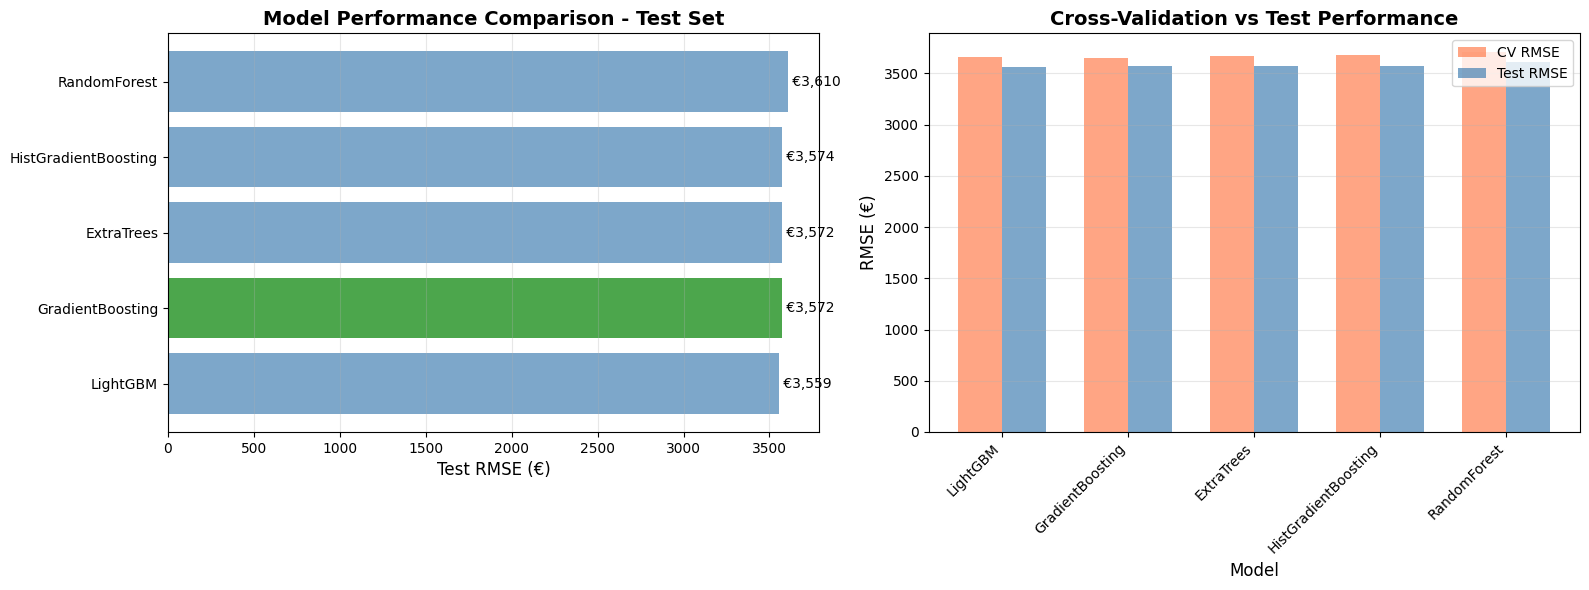


                           MODEL PERFORMANCE RANKINGS                           
Model                          CV RMSE    Test RMSE     Test MAE    Test R²
--------------------------------------------------------------------------------
LightGBM                    €     3,663 €     3,559 €     2,399     0.7977
GradientBoosting          ★ €     3,648 €     3,572 €     2,396     0.7962
ExtraTrees                  €     3,666 €     3,572 €     2,386     0.7961
HistGradientBoosting        €     3,680 €     3,574 €     2,415     0.7960
RandomForest                €     3,705 €     3,610 €     2,426     0.7918


In [14]:
# Model comparison summary
import matplotlib.pyplot as plt

results_df = pd.DataFrame(model_results, columns=['Model', 'CV_RMSE', 'Test_RMSE', 'Test_MAE', 'Test_R2'])
results_df = results_df.sort_values('Test_RMSE').reset_index(drop=True)

# Visualization - Compare Test RMSE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Test RMSE comparison
colors = ['green' if name == best_model_name else 'steelblue' for name in results_df['Model']]
bars = axes[0].barh(results_df['Model'], results_df['Test_RMSE'], color=colors, alpha=0.7)
axes[0].set_xlabel('Test RMSE (€)', fontsize=12)
axes[0].set_title('Model Performance Comparison - Test Set', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (model, rmse) in enumerate(zip(results_df['Model'], results_df['Test_RMSE'])):
    axes[0].text(rmse, i, f' €{rmse:,.0f}', va='center', fontsize=10)

# Plot 2: CV RMSE vs Test RMSE
x = np.arange(len(results_df))
width = 0.35
bars1 = axes[1].bar(x - width/2, results_df['CV_RMSE'], width, label='CV RMSE', alpha=0.7, color='coral')
bars2 = axes[1].bar(x + width/2, results_df['Test_RMSE'], width, label='Test RMSE', alpha=0.7, color='steelblue')
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('RMSE (€)', fontsize=12)
axes[1].set_title('Cross-Validation vs Test Performance', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print(f"{'MODEL PERFORMANCE RANKINGS':^80}")
print("="*80)
print(f"{'Model':<25} {'CV RMSE':>12} {'Test RMSE':>12} {'Test MAE':>12} {'Test R²':>10}")
print("-"*80)
for _, row in results_df.iterrows():
    marker = " ★" if row['Model'] == best_model_name else "  "
    print(f"{row['Model']:<25}{marker} €{row['CV_RMSE']:>10,.0f} €{row['Test_RMSE']:>10,.0f} €{row['Test_MAE']:>10,.0f} {row['Test_R2']:>10.4f}")
print("="*80)

In [15]:
# Display optimized hyperparameters for all models
print("="*80)
print(f"{'OPTIMIZED HYPERPARAMETERS':^80}")
print("="*80)

for model_name in optimization_tasks.keys():
    print(f"\n{model_name}:")
    for param, value in best_params[model_name].items():
        if isinstance(value, float):
            print(f"  {param}: {value:.6f}")
        else:
            print(f"  {param}: {value}")

                           OPTIMIZED HYPERPARAMETERS                            

LightGBM:
  n_estimators: 296
  learning_rate: 0.072164
  num_leaves: 21

GradientBoosting:
  n_estimators: 281
  learning_rate: 0.050536
  max_depth: 6
  min_samples_leaf: 6

RandomForest:
  n_estimators: 198
  max_depth: 22
  min_samples_leaf: 5

ExtraTrees:
  n_estimators: 287
  max_depth: 23
  min_samples_leaf: 5

HistGradientBoosting:
  max_iter: 234
  learning_rate: 0.054795
  max_depth: 9


## 6.1 Optimization History

Shows how Optuna improved over trials.

In [16]:
# Plot optimization history for best model
fig = plot_optimization_history(best_study)
fig.update_layout(
    title=f'Optimization History - {best_model_name}',
    xaxis_title='Trial Number',
    yaxis_title='CV RMSE (€)',
    width=900,
    height=500
)
fig.show()

best_cv_rmse = best_study.best_value
print(f"\nOptimization improved from €{best_study.trials[0].value:,.0f} to €{best_cv_rmse:,.0f}")
print(f"Improvement: €{best_study.trials[0].value - best_cv_rmse:,.0f} ({(best_study.trials[0].value - best_cv_rmse)/best_study.trials[0].value*100:.1f}%)")


Optimization improved from €3,697 to €3,648
Improvement: €49 (1.3%)


## 6.2 Hyperparameter Importance

Shows which hyperparameters had the biggest impact on performance.

In [17]:
# Plot hyperparameter importance for best model
fig = plot_param_importances(best_study)
fig.update_layout(
    title=f'Hyperparameter Importance - {best_model_name}',
    xaxis_title='Importance',
    yaxis_title='Hyperparameter',
    width=900,
    height=500
)
fig.show()

print(f"\nTop 3 most important hyperparameters for {best_model_name}:")


Top 3 most important hyperparameters for GradientBoosting:


# 7. Model Evaluation on Test Set

**Key Metrics:**
- **MAE (Mean Absolute Error)**: Average prediction error in euros - most interpretable
- **RMSE (Root Mean Squared Error)**: Penalizes larger errors more heavily
- **Median AE**: Robust to outliers, shows typical error
- **MAPE (Mean Absolute Percentage Error)**: Relative error as percentage
- **R² Score**: Proportion of variance explained (0-1, higher is better)

In [18]:
y_pred = best_model.predict(X_test_prep)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

# Guard RMSLE against negative predictions
rmsle = mean_squared_log_error(np.clip(y_test, 0, None), np.clip(y_pred, 0, None)) ** 0.5

print("="*60)
print(f"{'TEST SET PERFORMANCE':^60}")
print("="*60)
print(f"\n{'Primary Metrics (most important):':<40}")
print(f"  {'MAE (avg error):':<35} €{mae:>10,.0f}")
print(f"  {'RMSE (error with penalty):':<35} €{rmse:>10,.0f}")
print(f"  {'Median Absolute Error:':<35} €{medae:>10,.0f}")
print(f"  {'R² Score (variance explained):':<35} {r2:>10.3f}")
print(f"\n{'Additional Metrics:':<40}")
print(f"  {'MAPE (% error):':<35} {mape:>10.1%}")
print(f"  {'RMSLE (log error):':<35} {rmsle:>10.4f}")
print(f"  {'Explained Variance:':<35} {evs:>10.3f}")
print("="*60)

                    TEST SET PERFORMANCE                    

Primary Metrics (most important):       
  MAE (avg error):                    €     2,396
  RMSE (error with penalty):          €     3,572
  Median Absolute Error:              €     1,640
  R² Score (variance explained):           0.796

Additional Metrics:                     
  MAPE (% error):                          13.9%
  RMSLE (log error):                      0.1845
  Explained Variance:                      0.796


## 7.1 Prediction Diagnostics

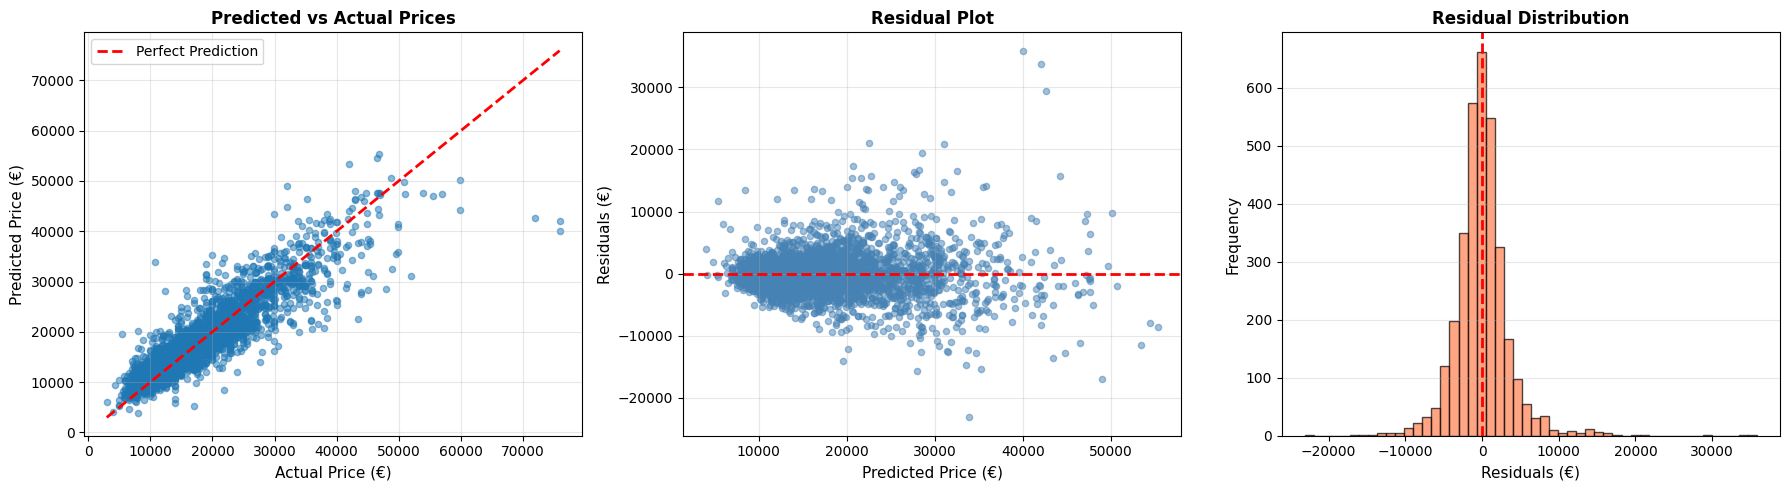

Residual Statistics:
  Mean: €-62 (should be ~0)
  Std Dev: €3,572
  Within ±€5k: 89.2%
  Within ±€10k: 98.1%


In [19]:
# Predicted vs Actual and Residual Analysis
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Predicted vs Actual
axes[0].scatter(y_test, y_pred, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price (€)', fontsize=11)
axes[0].set_ylabel('Predicted Price (€)', fontsize=11)
axes[0].set_title('Predicted vs Actual Prices', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Residual Plot
axes[1].scatter(y_pred, residuals, alpha=0.5, s=20, color='steelblue')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price (€)', fontsize=11)
axes[1].set_ylabel('Residuals (€)', fontsize=11)
axes[1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# 3. Residual Distribution
axes[2].hist(residuals, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Residuals (€)', fontsize=11)
axes[2].set_ylabel('Frequency', fontsize=11)
axes[2].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Residual Statistics:")
print(f"  Mean: €{residuals.mean():,.0f} (should be ~0)")
print(f"  Std Dev: €{residuals.std():,.0f}")
print(f"  Within ±€5k: {(abs(residuals) <= 5000).sum() / len(residuals) * 100:.1f}%")
print(f"  Within ±€10k: {(abs(residuals) <= 10000).sum() / len(residuals) * 100:.1f}%")

## 7.2 Feature Importance Analysis

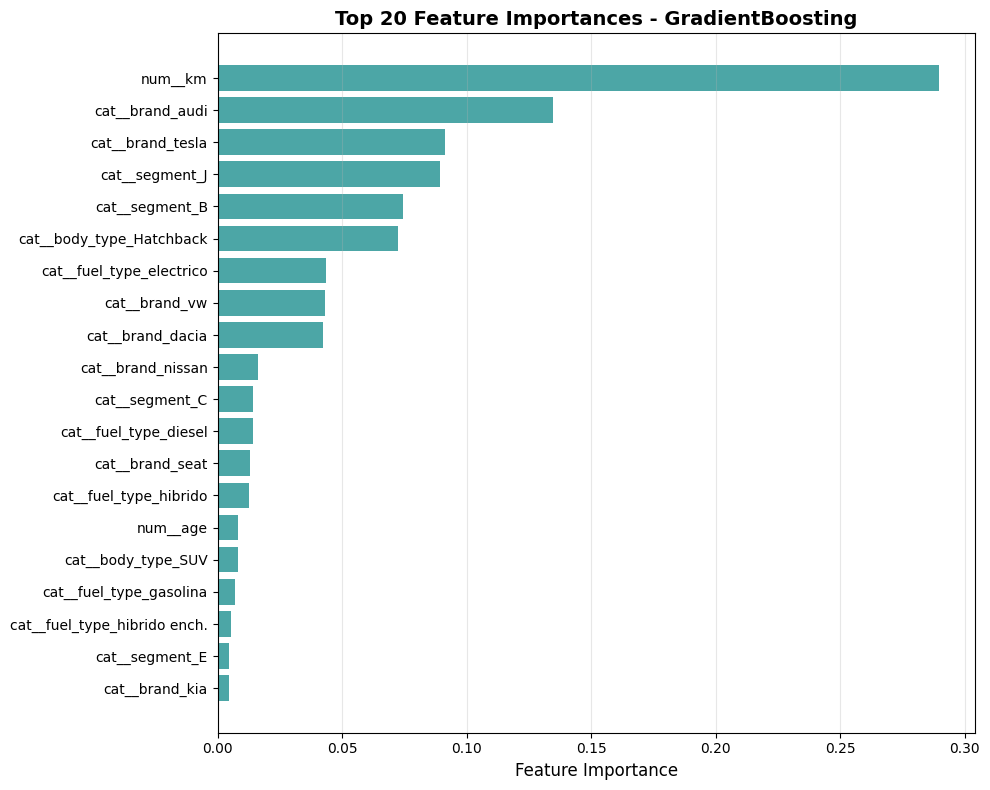

Top 10 Most Important Features:
  num__km                                  0.2896
  cat__brand_audi                          0.1346
  cat__brand_tesla                         0.0911
  cat__segment_J                           0.0891
  cat__segment_B                           0.0743
  cat__body_type_Hatchback                 0.0725
  cat__fuel_type_electrico                 0.0435
  cat__brand_vw                            0.0429
  cat__brand_dacia                         0.0423
  cat__brand_nissan                        0.0164


In [20]:
# Extract feature importance (if model supports it)
if hasattr(best_model, 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = preprocessor.get_feature_names_out()
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(20)
    
    # Plot top 20 features
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(importance_df['feature'], importance_df['importance'], color='teal', alpha=0.7)
    ax.set_xlabel('Feature Importance', fontsize=12)
    ax.set_title(f'Top 20 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    for i, row in importance_df.head(10).iterrows():
        print(f"  {row['feature']:40} {row['importance']:.4f}")
else:
    print(f"{best_model_name} does not provide feature importance.")

## 7.3 Sample Predictions

In [21]:
# Show sample predictions with errors
test_results = X_test.copy()
test_results['actual_price'] = y_test.values
test_results['predicted_price'] = y_pred
test_results['error'] = y_test.values - y_pred
test_results['abs_error'] = abs(test_results['error'])
test_results['pct_error'] = (test_results['error'] / test_results['actual_price'] * 100)

print("Sample of Best Predictions (lowest absolute error):")
best_preds = test_results.nsmallest(5, 'abs_error')[
    ['brand', 'segment', 'age', 'km', 'fuel_type', 'actual_price', 'predicted_price', 'error']
]
for idx, row in best_preds.iterrows():
    print(f"\n{row['brand']} {row['segment']} | Age: {row['age']:.0f}y | {row['km']:,.0f}km | {row['fuel_type']}")
    print(f"  Actual: €{row['actual_price']:,.0f} | Predicted: €{row['predicted_price']:,.0f} | Error: €{row['error']:,.0f}")

print("\n" + "="*80)
print("Sample of Worst Predictions (highest absolute error):")
worst_preds = test_results.nlargest(5, 'abs_error')[
    ['brand', 'segment', 'age', 'km', 'fuel_type', 'actual_price', 'predicted_price', 'error']
]
for idx, row in worst_preds.iterrows():
    print(f"\n{row['brand']} {row['segment']} | Age: {row['age']:.0f}y | {row['km']:,.0f}km | {row['fuel_type']}")
    print(f"  Actual: €{row['actual_price']:,.0f} | Predicted: €{row['predicted_price']:,.0f} | Error: €{row['error']:,.0f}")

Sample of Best Predictions (lowest absolute error):

dacia B | Age: 4y | 51,473km | diesel
  Actual: €10,490 | Predicted: €10,489 | Error: €1

citroen C | Age: 2y | 46,870km | diesel
  Actual: €18,690 | Predicted: €18,692 | Error: €-2

seat C | Age: 6y | 145,000km | diesel
  Actual: €13,990 | Predicted: €13,988 | Error: €2

skoda B | Age: 1y | 78,177km | diesel
  Actual: €17,980 | Predicted: €17,977 | Error: €3

mazda C | Age: 9y | 6,000km | hibrido
  Actual: €29,600 | Predicted: €29,606 | Error: €-6

Sample of Worst Predictions (highest absolute error):

audi J | Age: 11y | 30,000km | diesel
  Actual: €75,900 | Predicted: €40,011 | Error: €35,889

audi J | Age: 1y | 30,000km | diesel
  Actual: €75,900 | Predicted: €42,109 | Error: €33,791

audi J | Age: 3y | 7,000km | diesel
  Actual: €71,999 | Predicted: €42,646 | Error: €29,353

seat J | Age: 5y | 28,000km | gasolina
  Actual: €10,800 | Predicted: €33,933 | Error: €-23,133

audi C | Age: 10y | 145,000km | diesel
  Actual: €43,500 | 

# 8. Save Model

In [22]:
date_str = datetime.date.today().isoformat()
out_dir = os.path.join('..', 'models', date_str)
os.makedirs(out_dir, exist_ok=True)

sklearn_path = os.path.join(out_dir, 'auto_ml_sklearn.pkl')
joblib.dump(best_pipeline, sklearn_path)
print(f'✓ Saved sklearn model to {sklearn_path}')
print(f'\nModel: {best_model_name} (Optuna-optimized)')
print(f'Optimization trials: {len(best_study.trials)}')
print(f'CV RMSE: €{best_cv_rmse:,.0f}')
print(f'Test RMSE: €{rmse:,.0f}')
print(f'Test R²: {r2:.3f}')

✓ Saved sklearn model to ..\models\2026-02-04\auto_ml_sklearn.pkl

Model: GradientBoosting (Optuna-optimized)
Optimization trials: 30
CV RMSE: €3,648
Test RMSE: €3,572
Test R²: 0.796
